In [95]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

RAW_LOG = "logs/raw/workload_log_20251121_123947.txt"
ANON_LOG = "logs/anon/workload_log_20251121_124155.txt"

In [96]:
def parse_log(path):
    """
    Parse a workload log and return a DataFrame with:
    - raw_query
    - run_query
    - planning_ms
    - execution_ms
    - pure_execution_ms
    - memory
    - rows
    - db_hits
    """
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    # Split into query blocks
    blocks = re.split(r"--- Query \d+ ---", text)[1:]

    data = {
        "raw_query": [],
        "run_query": [],
        "planning_ms": [],
        "execution_ms": [],
        "pure_execution_ms": [],
        "memory": [],
        "rows": [],
        "db_hits": [],
    }

    for block in blocks:
        # Extract fields
        raw_q = re.search(r"RAW:\s*(.*)", block)
        run_q = re.search(r"RUN:\s*(.*)", block)
        planning = re.search(r"Planning:\s*([0-9\-]+)", block)
        execution = re.search(r"Execution:\s*([0-9\-]+)", block)
        pure_exec = re.search(r"Pure Exec:\s*([0-9\-]+)", block)
        memory = re.search(r"Memory:\s*([0-9]+)", block)
        rows = re.search(r"Rows:\s*([0-9\?]+)", block)
        db_hits = re.search(r"DB Hits:\s*([0-9\?]+)", block)

        # Append to lists
        data["raw_query"].append(raw_q.group(1).strip() if raw_q else None)
        data["run_query"].append(run_q.group(1).strip() if run_q else None)
        data["planning_ms"].append(int(planning.group(1)) if planning else None)
        data["execution_ms"].append(int(execution.group(1)) if execution else None)
        data["pure_execution_ms"].append(int(pure_exec.group(1)) if pure_exec else None)
        data["memory"].append(int(memory.group(1)) if memory else None)
        data["rows"].append(int(rows.group(1)) if rows and rows.group(1).isdigit() else None)
        data["db_hits"].append(int(db_hits.group(1)) if db_hits and db_hits.group(1).isdigit() else None)

    return pd.DataFrame(data)

In [97]:
df_raw["type"] = "raw"
df_anon["type"] = "anon"

df_all = pd.concat([df_raw, df_anon], ignore_index=True)

In [98]:
summary = df_all.groupby("type")[["planning_ms", "execution_ms", "pure_execution_ms", "memory"]].mean()
summary


,planning_ms,execution_ms,pure_execution_ms,memory
type,,,,
anon,5.756,67.260,66.528,321.6
raw,22.932,116.436,100.304,321.6


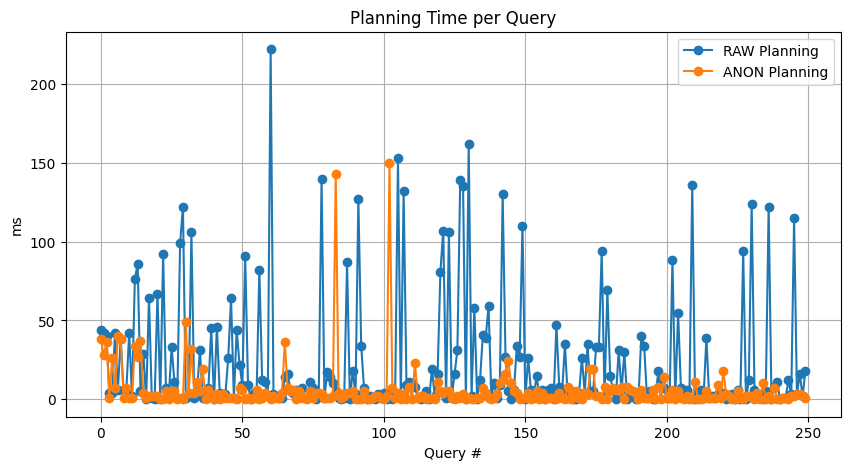

In [99]:
plt.figure(figsize=(10,5))

plt.plot(df_raw["planning_ms"], label="RAW Planning", marker="o")
plt.plot(df_anon["planning_ms"], label="ANON Planning", marker="o")

plt.title("Planning Time per Query")
plt.xlabel("Query #")
plt.ylabel("ms")
plt.legend()
plt.grid(True)
plt.show()


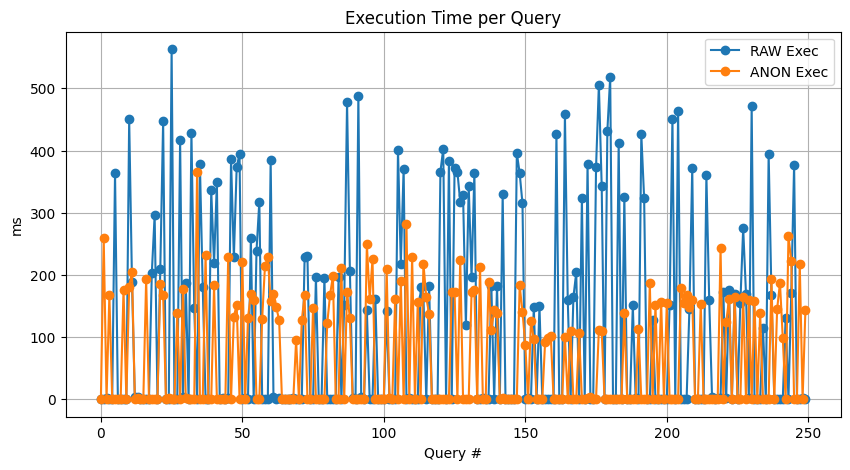

In [100]:
plt.figure(figsize=(10,5))

plt.plot(df_raw["execution_ms"], label="RAW Exec", marker="o")
plt.plot(df_anon["execution_ms"], label="ANON Exec", marker="o")

plt.title("Execution Time per Query")
plt.xlabel("Query #")
plt.ylabel("ms")
plt.legend()
plt.grid(True)
plt.show()


In [101]:
improvement = (df_raw["planning_ms"].mean() - df_anon["planning_ms"].mean())
percent = improvement / df_raw["planning_ms"].mean() * 100

print(f"Average Planning Improvement: {improvement:.2f} ms ({percent:.2f}%)")


Average Planning Improvement: 17.18 ms (74.90%)
